In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import imutils
from sklearn.cluster import KMeans
import scipy.stats as st

In [2]:
# New Functions that works:
def Gaussiankernel(size, sigma=1):
    """create 2D gaussian Kernel by taking in kernel size and sigma value as inputs"""    
    size = int(size) // 2
    # create x grid and y grid
    x, y = np.mgrid[-size:size+1, -size:size+1] 
    # gaussian distribution formula
    normal = 1 / np.sqrt(2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    return g/g.sum()

def MVgaussian(size,mu1=0,mu2=0, sigma1=3,sigma2 = 1):
    """create 2 1D gaussian Kernels by taking in same kernel size and sigma value that sigy = 3sigx, and form 2D kernel"""
    kernel = np.zeros((size, size), dtype=np.float32)
    
    size = int(size) // 2
    X = np.arange(-size,size+1)
    Y = np.arange(-size,size+1)
    
    for x in X:
        for y in Y:
            Gx = np.exp(-((x-mu1)**2)/(2*(sigma1**2)))
            Gy = np.exp(-((y-mu2)**2)/(2*(sigma2**2)))
            Gx = math.exp(-(math.pow(x-mu1,2))/(2*math.pow(sigma1,2)))
            Gy = math.exp(-(math.pow(y-mu2,2))/(2*math.pow(sigma2,2)))
            kernel[x+size,y+size] = Gx*Gy
    return kernel

# generate Filter banks :
def OrientedDoG(size=7,scales=[1,2],n_orientations=8):

    """
    DoG (Difference of Gaussian) Filter is generated by convolving Sobel Kernel with a Gaussian Kernel under a given size, orientation and scale. 
    ie obtain first derivative of Gaussian Kernel.

    DoG Filter Bank is a set of DoG filters generated by obtaining first derivative of Gaussian kernels under various orientations and
    scales for a given size
    """

    filt_count = 0
    # declare the sobel kernel
    sobel_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)

    # pre define a dummy filter bank
    n_filters = len(scales)*n_orientations
    filterBank = np.zeros((size,size,n_filters), dtype=np.float32)
    
    # for a given scale
    for s in scales: 
         # generate gaussian kernel
        gaussian_kernel = Gaussiankernel(size, sigma=s)

    # and obtain first derivative of the gaussian kernel by convolving
        DoG = cv2.filter2D(gaussian_kernel, -1, sobel_kernel) 

        # split orientations
        degreeRotation = 360.0/n_orientations 
        
        for o in range(n_orientations):
            angle = o*degreeRotation
            filterBank[:,:,filt_count] = imutils.rotate(DoG,angle)
            filt_count+=1
    
    if filt_count == n_filters: 
        return filterBank
    else:
        print('Error in generating Bank')
        return None

    
def LM_OrientedFilters(size = 29,scales = [1,np.sqrt(2),2] ,n_orientations  = 6):
    """LM Filters : DoG and D2oG (with elongation ) for 6 orientations and 3 scales = 36; LoG =8 ; Gaussians =4 ; Total =48"""

    # initialise
    n_filters = 48
    filt_count=0
    sobel_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)
    DoGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)
    D2oGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)

    # create DoG and D2oG
    # create Gaussian Kernel with scale and elongation:
    for s in scales:
        """Doubt to clarify:  method 2 has all correct elements except at 0 degeree which looks inverted"""        
        mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = s,sigma2 = 3*s)
        DoG = cv2.filter2D(mvkernel, -1, sobel_kernel.T)
        D2oG = cv2.filter2D(DoG, -1, sobel_kernel.T)

        """Doubt to clarify:  method 2 has all correct elements except at 120 and 150 degrees which looks inverted"""
    #     mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = 3*s,sigma2 = 1*s)
    #     DoG = cv2.filter2D(mvkernel, -1, sobel_kernel) 
    #     D2oG = cv2.filter2D(DoG, -1, sobel_kernel)  

        # split orientations
        degreeRotation = 180.0/n_orientations 

        for o in range(n_orientations):
            angle = o*degreeRotation
            DoGfilterBank[:,:,filt_count] = imutils.rotate(DoG,angle)
            D2oGfilterBank[:,:,filt_count] = imutils.rotate(D2oG,angle)
            filt_count+=1

    if filt_count != len(scales)*n_orientations:
        print(filt_count)
        print('Error in generating LM filter Bank - DoGs')
        return None
    else:
        OrientedFilters = np.dstack((DoGfilterBank,D2oGfilterBank))
        return OrientedFilters
    
def LM_LoGFilters(size = 29, scales = [1,np.sqrt(2),2,2*np.sqrt(2),3,4,3*np.sqrt(2),4*np.sqrt(2)]):

    laplacian_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]], dtype=np.float32)
    LoGFilters = np.zeros((size,size,len(scales)), dtype=np.float32)

    for i,s in enumerate(scales):
        gaussian_kernel = Gaussiankernel(size, sigma=s)
        LoGFilters[:,:,i] = cv2.filter2D(gaussian_kernel, -1, laplacian_kernel)

    return LoGFilters

def LM_GaussianFilters(size = 29, scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]):

    GaussianFilters = np.zeros((size,size,len(scales)), dtype=np.float32)
    for i,s in enumerate(scales):
        GaussianFilters[:,:,i] = Gaussiankernel(size, sigma=s)

    return GaussianFilters

def LM_FilterBank(size=29):

    scales = [2,np.sqrt(2),1]
    
    OrientedFilters = LM_OrientedFilters(size,scales ,n_orientations  = 6)

    scales = [1,np.sqrt(2),2,2*np.sqrt(2),3,4,3*np.sqrt(2),4*np.sqrt(2)]
    LoGFilters = LM_LoGFilters(size,scales)

    scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]
    GaussianFilters = LM_GaussianFilters(size,scales)
    
    return np.dstack((OrientedFilters ,LoGFilters, GaussianFilters))



def gaborFilter(size, sigma, theta, lamda, gamma, psi):

    size = size//2
    x, y = np.mgrid[-size:size+1,-size:size+1]
    
    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)


    GaussianTerm = np.exp((-0.5/sigma ** 2) * ( x1 ** 2 + gamma ** 2 *y1 ** 2 )) 
    SinusoidTerm = np.cos(2 * np.pi / lamda * x1 + psi)
        

    return GaussianTerm*SinusoidTerm


def GaborFilterBank(size,params,n_orientations = 8):

    degreeRotation = 180/n_orientations
    gaborFilterBank =  np.zeros((size,size,len(params)*n_orientations), dtype=np.float32)


    filt_count=  0
    for param in params:
        for o in range(n_orientations):
            theta = -degreeRotation*o 

            gaborFilterBank[:,:,filt_count] = gaborFilter(size=size,sigma = param[0],theta= theta,lamda = param[1],gamma = param[2],psi = 0)
            filt_count +=1
            
    if filt_count==len(params)*n_orientations:
        return gaborFilterBank
    else:
        print('Error generating gabor Filter bank')
        return None
    
    
def getTexton(imGray,FilterBank,K=64):
    n_filters = FilterBank.shape[2]
    width,height = imGray.shape
    FilterBankresponse = np.zeros((width,height, n_filters), dtype=np.float32)

    for filt_count in range(n_filters):
        FilterBankresponse[:,:,filt_count] = cv2.filter2D(imGray, -1, FilterBank[:,:,filt_count])

    flattenedResponse = FilterBankresponse.reshape((-1,n_filters)).astype(np.float32)
    
    # Vector Quantization using Kmeans
    kmeans = KMeans(n_clusters=K, random_state=0).fit(flattenedResponse)
    labels = kmeans.labels_
    # reshape to reconstruct spatial info
    Tmap = labels.reshape(width,height)
    return Tmap

    # Put All Textons together
def getFilterResponse(imGray,FilterBank):
    n_filters = FilterBank.shape[2]
    width,height = imGray.shape
    FilterBankresponse = np.zeros((width,height, n_filters), dtype=np.float32)

    for filt_count in range(n_filters):
        FilterBankresponse[:,:,filt_count] = cv2.filter2D(imGray, -1, FilterBank[:,:,filt_count])
    
    return FilterBankresponse

def do_Kmeans(FilterResponse,K= 64 ):
    
    if len(FilterResponse.shape)>2:
        width,height,n_filters = FilterResponse.shape
    else:
        width,height = FilterResponse.shape
        n_filters = 1

    flattenedResponse = FilterResponse.reshape((-1,n_filters)).astype(np.float32)
    
    # Vector Quantization using Kmeans
    kmeans = KMeans(n_clusters=K, random_state=0).fit(flattenedResponse)
    labels = kmeans.labels_
    # reshape to reconstruct spatial info
    Tmap = labels.reshape(width,height)
    return Tmap

def do_KmeansCV(FilterResponse,K= 64 ):
    if len(FilterResponse.shape)>2:
        width,height,n_filters = FilterResponse.shape
    else:
        width,height = FilterResponse.shape
        n_filters = 1
        
    flattenedResponse = FilterResponse.reshape((-1,n_filters)).astype(np.float32)

    # Vector Quantization using Kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(flattenedResponse,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # reshape to reconstruct spatial info
    Tmap_ = label.reshape(width,height)
    
    return Tmap_

def getCircularKernel(size):
    radius = size//2
    thickness = -1
    color = 255
    centre = (size//2,size//2)
    Halfmask = np.zeros((size, size), dtype=np.float32)
    cv2.circle(Halfmask, centre, radius, color, thickness)
    Halfmask[:size//2+1,:] = 0
    return Halfmask

#     Halfmask =  np.where(Halfmask > 0, 1, 0)
#     return Halfmask.astype(np.float32)

def getHalfDisks(size1,size2,size3,n_Diskorientations = 16):
    
    mask1 = getCircularKernel(size1)
    mask2 = getCircularKernel(size2)
    mask3 = getCircularKernel(size3)

    HalfDiskBank1 = np.zeros((size1, size1, n_Diskorientations), dtype=np.float32)
    HalfDiskBank2 = np.zeros((size2, size2, n_Diskorientations), dtype=np.float32)
    HalfDiskBank3 = np.zeros((size3, size3, n_Diskorientations), dtype=np.float32)


    degreeRotation = 360.0/n_Diskorientations 

    for o in range(n_Diskorientations):
        angle = o*degreeRotation
        HalfDiskBank1[:,:,o] = imutils.rotate(mask1,angle)
        HalfDiskBank2[:,:,o] = imutils.rotate(mask2,angle)
        HalfDiskBank3[:,:,o] = imutils.rotate(mask3,angle)

    return HalfDiskBank1,HalfDiskBank2,HalfDiskBank3

def getGradient(Tmap,num_bins,DiskBanks,n_Diskpairs):
    n_filters = len(DiskBanks)*n_Diskpairs # scales
    grad = np.zeros((Tmap.shape[0], Tmap.shape[1],n_filters), dtype=np.float32)

    ind=0
    
    dummyarr = np.ones((Tmap.shape),dtype=np.float32)*0.0000001
    
    for Disk in DiskBanks : # across varying scales
        rightDisks = Disk[:,:,:n_Diskpairs] # right disks at first half of the bank 
        leftDisks = Disk[:,:,n_Diskpairs:] # left disks at second half of the bank

        if leftDisks.shape[2] == rightDisks.shape[2]:
            print(leftDisks.shape[2],rightDisks.shape[2])
            for d in range(leftDisks.shape[2]):
                rightMask =  rightDisks[:,:,d]
                leftMask = leftDisks[:,:,d]
                chi = np.zeros((Tmap.shape[0], Tmap.shape[1]), dtype=np.float32) # re initialise chi for every new Disk pair
                
                for i in range(num_bins): 
                    tmp = Tmap.copy()
                    tmp[Tmap == i ] = 1.0
                    tmp[Tmap != i ] =0.0
                    gi = cv2.filter2D(tmp, -1, leftMask)
                    hi = cv2.filter2D(tmp, -1, rightMask)
                    chi = chi + ((gi - hi)**2 ) * (1/(gi + hi + dummyarr)) # infinitesimally small value matrix to avoid divided by zero error 

                grad[:,:,ind] = chi*0.5
                ind += 1
    gradmean = grad.mean(axis=2, dtype=np.float32)
    return gradmean

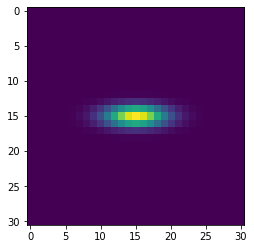

In [3]:
# Check if MultiVariate Kernel works
multivariateKernel  = MVgaussian(size=31,mu1=0,mu2=0, sigma1=1,sigma2 = 3)
plt.imshow(multivariateKernel)

In [4]:

def MVgaussian(size,mu1=0,mu2=0, sigma1=3,sigma2 = 1):
    """create 2D gaussian Kernel by taking in kernel size and sigma value as inputs"""
    kernel = np.zeros((size, size), dtype=np.float32)
    
    size = int(size) // 2
    X = np.arange(-size,size+1)
    Y = np.arange(-size,size+1)
    
    for x in X:
        for y in Y:
            Gx = np.exp(-((x-mu1)**2)/(2*(sigma1**2)))
            Gy = np.exp(-((y-mu2)**2)/(2*(sigma2**2)))
            Gx = math.exp(-(math.pow(x-mu1,2))/(2*math.pow(sigma1,2)))
            Gy = math.exp(-(math.pow(y-mu2,2))/(2*math.pow(sigma2,2)))
            kernel[x+size,y+size] = Gx*Gy
    return kernel


(29, 29, 48)


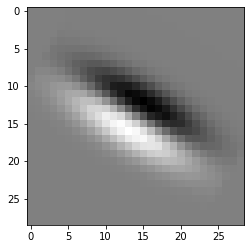

In [5]:
# Check if LM Filter works
LMFilterBank = LM_FilterBank(size=29)
print(LMFilterBank.shape)
plt.imshow(LMFilterBank[:,:,5],'gray')

In [6]:
def DifferentiateKernel(mvkernel,sobel_kernel):
    
    DoGx = cv2.filter2D(mvkernel, -1, sobel_kernel)
    DoGy = cv2.filter2D(mvkernel, -1, sobel_kernel.T)

    return DoGx + DoGy

def LM_OrientedFilters_(size = 29,scales = [1,np.sqrt(2),2] ,n_orientations  = 6):
    """LM Filters : DoG and D2oG (with elongation ) for 6 orientations and 3 scales = 36; LoG =8 ; Gaussians =4 ; Total =48"""

    # initialise
    filt_count=0
    sobel_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)
    DoGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)
    D2oGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)

    # create DoG and D2oG
    # create Gaussian Kernel with scale and elongation:
    for s in scales:
        """Doubt to clarify:  method 2 has all correct elements except at 0 degeree which looks inverted"""        
        mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = s,sigma2 = 3*s)
#         DoG = cv2.filter2D(mvkernel, -1, sobel_kernel.T)
#         D2oG = cv2.filter2D(DoG, -1, sobel_kernel.T)
        
        DoG = DifferentiateKernel(mvkernel,sobel_kernel)
        D2oG = DifferentiateKernel(DifferentiateKernel(mvkernel,sobel_kernel),sobel_kernel)
    
        """Doubt to clarify:  method 2 has all correct elements except at 120 and 150 degrees which looks inverted"""
    #     mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = 3*s,sigma2 = 1*s)
    #     DoG = cv2.filter2D(mvkernel, -1, sobel_kernel) 
    #     D2oG = cv2.filter2D(DoG, -1, sobel_kernel)  

        # split orientations
        degreeRotation = 180.0/n_orientations 

        for o in range(n_orientations):
            angle = o*degreeRotation
            DoGfilterBank[:,:,filt_count] = imutils.rotate(DoG,angle)
            D2oGfilterBank[:,:,filt_count] = imutils.rotate(D2oG,angle)
            filt_count+=1

    if filt_count != len(scales)*n_orientations:
        print(filt_count)
        print('Error in generating LM filter Bank - DoGs')
        return None
    else:
        OrientedFilters = np.dstack((DoGfilterBank,D2oGfilterBank))
        return OrientedFilters
    
def LM_FilterBank_(size=29):

    scales = [2,np.sqrt(2),1]
    
    OrientedFilters = LM_OrientedFilters_(size,scales ,n_orientations  = 6)

    scales = [1,np.sqrt(2),2,2*np.sqrt(2),3,4,3*np.sqrt(2),4*np.sqrt(2)]
    LoGFilters = LM_LoGFilters(size,scales)

    scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]
    GaussianFilters = LM_GaussianFilters(size,scales)
    
    return np.dstack((OrientedFilters ,LoGFilters, GaussianFilters))



(29, 29, 48)


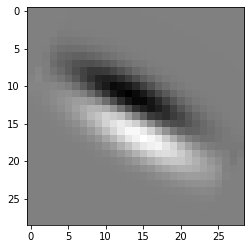

In [7]:
LMFilterBank_ = LM_FilterBank_(size=29)
print(LMFilterBank_.shape)
plt.imshow(LMFilterBank_[:,:,5],'gray')

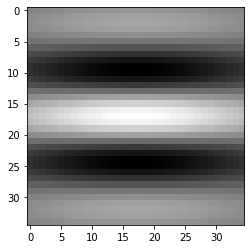

In [8]:
# Check if gabor Filter Works

size = 35 # constant
sigma = 11
lamda = 5*np.pi
gamma = 0.7 # constant
theta = 0
psi = 0 # constant

gabor = gaborFilter(size,sigma,theta,lamda,gamma,psi)

plt.imshow(gabor,'gray')    

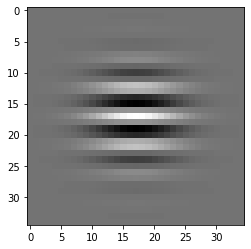

In [9]:
# check if gabor Filter Bank is generated

params = [[4,1.2*np.pi,1],[5,1.5*np.pi,1],[6,1.9*np.pi,1],[7,3*np.pi,0.7],[11,5*np.pi,0.7]]
gaborFilterBank = GaborFilterBank(size,params,n_orientations = 8)
plt.imshow(gaborFilterBank[:,:,8],'gray')

In [10]:
# generate texton maps

# Oriented DOG Textons

(15, 15, 16)
(29, 29, 48)
(29, 29, 40)


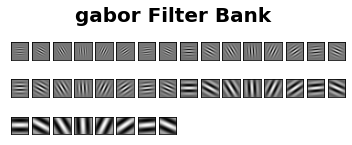

In [30]:

n_filters = gaborFilterBank.shape[2]

Fig1 = plt.figure()
for i in range(n_filters):
    ax = Fig1.add_subplot(6, 16, i+1)
    plt.imshow(gaborFilterBank[:,:,i],'gray')
    ax.set_xticks([])
    ax.set_yticks([])

Fig1.suptitle("gabor Filter Bank", fontsize=20, fontweight = 'bold')
plt.savefig('gaborFilterBank.png')	


(15, 15, 16)


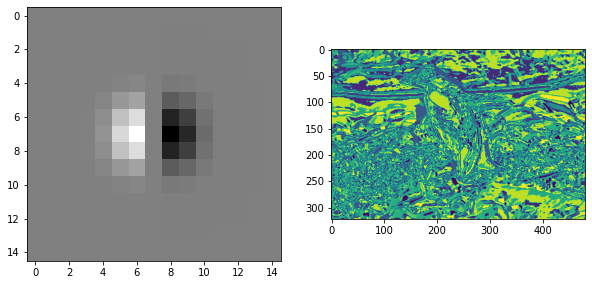

In [7]:
imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

O_Tmap = getTexton(imGray,OrientedDoGFilterBank,K=64)
# default gaussian kernel
fx,plts = plt.subplots(1,2,figsize = [10,5])
plts[0].imshow(OrientedDoGFilterBank[:,:,0],'gray')
plts[1].imshow(O_Tmap)

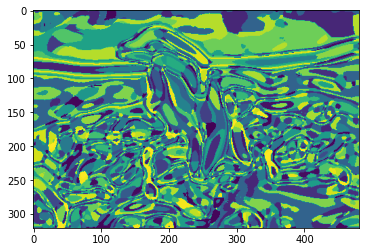

In [44]:
# with new gaussian kernel
plt.imshow(O_Tmap) # size =31

# LM Texton

(29, 29, 48)


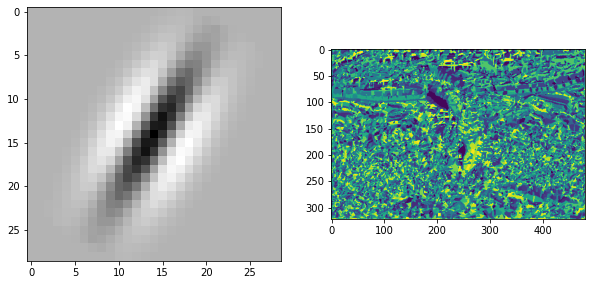

In [8]:

L_Tmap = getTexton(imGray,LMFilterBank,K=64)

fx,plts = plt.subplots(1,2,figsize = [10,5])
plts[0].imshow(LMFilterBank[:,:,20],'gray')
plts[1].imshow(L_Tmap)

# Gabor Textons

(29, 29, 40)


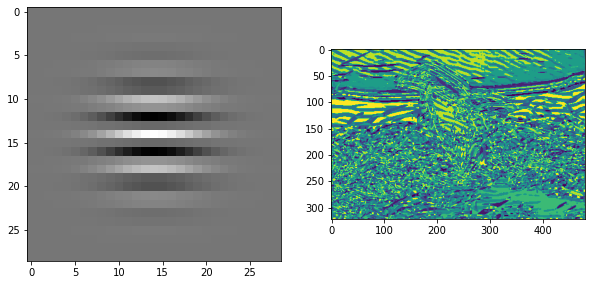

In [9]:

G_Tmap = getTexton(imGray,gaborFilterBank,K=64)
fx,plts = plt.subplots(1,2,figsize = [10,5])
plts[0].imshow(gaborFilterBank[:,:,0],'gray')
plts[1].imshow(G_Tmap)

In [57]:
size1,size2,size3 = 11,21,31
n_Diskorientations = 16
HalfDisk1,HalfDisk2,HalfDisk3 = getHalfDisks(size1,size2,size3,n_Diskorientations = n_Diskorientations)

HD = [HalfDisk1[:,:,i] for i in  range(n_Diskorientations)]
for i in  range(n_Diskorientations):
    HD.append(HalfDisk2[:,:,i])

for i in  range(n_Diskorientations):
    HD.append(HalfDisk3[:,:,i])

Fig1 = plt.figure()
for i in range(len(HD)):
    ax = Fig1.add_subplot(6, 8, i+1)
    plt.imshow(HD[i],'gray')
    ax.set_xticks([])
    ax.set_yticks([])

Fig1.suptitle("Half Disk banks", fontsize=20, fontweight = 'bold')
plt.savefig('halfDiskBank.png')

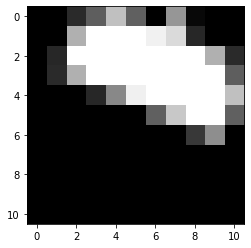

In [58]:
plt.imshow(HalfDisk1[:,:,7],'gray')

In [ ]:
# Tmap = getTexton(imGray,FilterResponse,K=64)
# L_Tmap = getTexton(imGray,LMFilterBank,K=64)
# G_Tmap = getTexton(imGray,gaborFilterBank,K=64)


# Run Once

In [3]:
def Gaussiankernel(size, sigma=1):
    """create 2D gaussian Kernel by taking in kernel size and sigma value as inputs"""    
    size = int(size) // 2
    # create x grid and y grid
    x, y = np.mgrid[-size:size+1, -size:size+1] 
    # gaussian distribution formula
    normal = 1 / np.sqrt(2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    return g/g.sum()

def MVgaussian(size,mu1=0,mu2=0, sigma1=3,sigma2 = 1):
    """create 2 1D gaussian Kernels by taking in same kernel size and sigma value that sigy = 3sigx, and form 2D kernel"""
    kernel = np.zeros((size, size), dtype=np.float32)
    
    size = int(size) // 2
    X = np.arange(-size,size+1)
    Y = np.arange(-size,size+1)
    
    for x in X:
        for y in Y:
            Gx = np.exp(-((x-mu1)**2)/(2*(sigma1**2)))
            Gy = np.exp(-((y-mu2)**2)/(2*(sigma2**2)))
            Gx = math.exp(-(math.pow(x-mu1,2))/(2*math.pow(sigma1,2)))
            Gy = math.exp(-(math.pow(y-mu2,2))/(2*math.pow(sigma2,2)))
            kernel[x+size,y+size] = Gx*Gy
    return kernel

# generate Filter banks :
def OrientedDoG(size=7,scales=[1,2],n_orientations=8):

    """
    DoG (Difference of Gaussian) Filter is generated by convolving Sobel Kernel with a Gaussian Kernel under a given size, orientation and scale. 
    ie obtain first derivative of Gaussian Kernel.

    DoG Filter Bank is a set of DoG filters generated by obtaining first derivative of Gaussian kernels under various orientations and
    scales for a given size
    """

    filt_count = 0
    # declare the sobel kernel
    sobel_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)

    # pre define a dummy filter bank
    n_filters = len(scales)*n_orientations
    filterBank = np.zeros((size,size,n_filters), dtype=np.float32)
    
    # for a given scale
    for s in scales: 
         # generate gaussian kernel
        gaussian_kernel = Gaussiankernel(size, sigma=s)

    # and obtain first derivative of the gaussian kernel by convolving
        DoG = cv2.filter2D(gaussian_kernel, -1, sobel_kernel) 

        # split orientations
        degreeRotation = 360.0/n_orientations 
        
        for o in range(n_orientations):
            angle = o*degreeRotation
            filterBank[:,:,filt_count] = imutils.rotate(DoG,angle)
            filt_count+=1
    
    if filt_count == n_filters: 
        return filterBank
    else:
        print('Error in generating Bank')
        return None

    
def LM_OrientedFilters(size = 29,scales = [1,np.sqrt(2),2] ,n_orientations  = 6):
    """LM Filters : DoG and D2oG (with elongation ) for 6 orientations and 3 scales = 36; LoG =8 ; Gaussians =4 ; Total =48"""

    # initialise
    n_filters = 48
    filt_count=0
    sobel_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)
    DoGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)
    D2oGfilterBank = np.zeros((size,size,len(scales)*n_orientations), dtype=np.float32)

    # create DoG and D2oG
    # create Gaussian Kernel with scale and elongation:
    for s in scales:
        """Doubt to clarify:  method 2 has all correct elements except at 0 degeree which looks inverted"""        
        mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = s,sigma2 = 3*s)
        DoG = cv2.filter2D(mvkernel, -1, sobel_kernel.T)
        D2oG = cv2.filter2D(DoG, -1, sobel_kernel.T)

        """Doubt to clarify:  method 2 has all correct elements except at 120 and 150 degrees which looks inverted, IS IT CRITICAL TO MAINTAIN EXACT SAME ORIENTATION ?
        
        """
    #     mvkernel = MVgaussian(size,mu1=0,mu2=0,sigma1 = 3*s,sigma2 = 1*s)
    #     DoG = cv2.filter2D(mvkernel, -1, sobel_kernel) 
    #     D2oG = cv2.filter2D(DoG, -1, sobel_kernel)  

        # split orientations
        degreeRotation = 180.0/n_orientations 

        for o in range(n_orientations):
            angle = o*degreeRotation
            DoGfilterBank[:,:,filt_count] = imutils.rotate(DoG,angle)
            D2oGfilterBank[:,:,filt_count] = imutils.rotate(D2oG,angle)
            filt_count+=1

    if filt_count != len(scales)*n_orientations:
        print('Error in generating LM filter Bank - DoGs')
        return None
    else:
        OrientedFilters = np.dstack((DoGfilterBank,D2oGfilterBank))
        return OrientedFilters
    
def LM_LoGFilters(size = 29, scales = [1,np.sqrt(2),2,2*np.sqrt(2),3,4,3*np.sqrt(2),4*np.sqrt(2)]):

    laplacian_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]], dtype=np.float32)
    LoGFilters = np.zeros((size,size,len(scales)), dtype=np.float32)

    for i,s in enumerate(scales):
        gaussian_kernel = Gaussiankernel(size, sigma=s)
        LoGFilters[:,:,i] = cv2.filter2D(gaussian_kernel, -1, laplacian_kernel)

    return LoGFilters

def LM_GaussianFilters(size = 29, scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]):

    GaussianFilters = np.zeros((size,size,len(scales)), dtype=np.float32)
    for i,s in enumerate(scales):
        GaussianFilters[:,:,i] = Gaussiankernel(size, sigma=s)

    return GaussianFilters

def LM_FilterBank(size=29):

    scales = [2,np.sqrt(2),1]
    
    OrientedFilters = LM_OrientedFilters(size,scales ,n_orientations  = 6)

    scales = [1,np.sqrt(2),2,2*np.sqrt(2),3,4,3*np.sqrt(2),4*np.sqrt(2)]
    LoGFilters = LM_LoGFilters(size,scales)

    scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]
    GaussianFilters = LM_GaussianFilters(size,scales)
    
    return np.dstack((OrientedFilters ,LoGFilters, GaussianFilters))



def gaborFilter(size, sigma, theta, lamda, gamma, psi):

    size = size//2
    x, y = np.mgrid[-size:size+1,-size:size+1]
    
    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)


    GaussianTerm = np.exp((-0.5/sigma ** 2) * ( x1 ** 2 + gamma ** 2 *y1 ** 2 )) 
    SinusoidTerm = np.cos(2 * np.pi / lamda * x1 + psi)
        

    return GaussianTerm*SinusoidTerm


def GaborFilterBank(size,params,n_orientations = 8):

    degreeRotation = 180/n_orientations
    gaborFilterBank =  np.zeros((size,size,len(params)*n_orientations), dtype=np.float32)


    filt_count=  0
    for param in params:
        for o in range(n_orientations):
            theta = -degreeRotation*o 

            gaborFilterBank[:,:,filt_count] = gaborFilter(size=size,sigma = param[0],theta= theta,lamda = param[1],gamma = param[2],psi = 0)
            filt_count +=1
            
    if filt_count==len(params)*n_orientations:
        return gaborFilterBank
    else:
        print('Error generating gabor Filter bank')
        return None
    
    
def getTexton(imGray,FilterBank,K=64):
    n_filters = FilterBank.shape[2]
    width,height = imGray.shape
    FilterBankresponse = np.zeros((width,height, n_filters), dtype=np.float32)

    for filt_count in range(n_filters):
        FilterBankresponse[:,:,filt_count] = cv2.filter2D(imGray, -1, FilterBank[:,:,filt_count])

    flattenedResponse = FilterBankresponse.reshape((-1,n_filters)).astype(np.float32)
    
    # Vector Quantization using Kmeans
    kmeans = KMeans(n_clusters=K, random_state=0).fit(flattenedResponse)
    labels = kmeans.labels_
    # reshape to reconstruct spatial info
    Tmap = labels.reshape(width,height)
    return Tmap

    # Put All Textons together
def getFilterResponse(imGray,FilterBank):
    n_filters = FilterBank.shape[2]
    width,height = imGray.shape
    FilterBankresponse = np.zeros((width,height, n_filters), dtype=np.float32)

    for filt_count in range(n_filters):
        FilterBankresponse[:,:,filt_count] = cv2.filter2D(imGray, -1, FilterBank[:,:,filt_count])
    
    return FilterBankresponse

def do_Kmeans(FilterResponse,K= 64 ):
    
    if len(FilterResponse.shape)>2:
        width,height,n_filters = FilterResponse.shape
    else:
        width,height = FilterResponse.shape
        n_filters = 1

    flattenedResponse = FilterResponse.reshape((-1,n_filters)).astype(np.float32)
    
    # Vector Quantization using Kmeans
    kmeans = KMeans(n_clusters=K, random_state=0).fit(flattenedResponse)
    labels = kmeans.labels_
    # reshape to reconstruct spatial info
    Tmap = labels.reshape(width,height)
    return Tmap

def do_KmeansCV(FilterResponse,K= 64 ):
    if len(FilterResponse.shape)>2:
        width,height,n_filters = FilterResponse.shape
    else:
        width,height = FilterResponse.shape
        n_filters = 1
        
    flattenedResponse = FilterResponse.reshape((-1,n_filters)).astype(np.float32)

    # Vector Quantization using Kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(flattenedResponse,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # reshape to reconstruct spatial info
    Tmap_ = label.reshape(width,height)
    
    return Tmap_

def getCircularKernel(size):
    radius = size//2
    thickness = -1
    color = 255
    centre = (size//2,size//2)
    Halfmask = np.zeros((size, size), dtype=np.float32)
    cv2.circle(Halfmask, centre, radius, color, thickness)
    Halfmask[:size//2+1,:] = 0
    return Halfmask

#     Halfmask =  np.where(Halfmask > 0, 1, 0)
#     return Halfmask.astype(np.float32)

def getHalfDisks(size1,size2,size3,n_Diskorientations = 8):
    
    mask1 = getCircularKernel(size1)
    mask2 = getCircularKernel(size2)
    mask3 = getCircularKernel(size3)

    HalfDiskBank1 = np.zeros((size1, size1,n_Diskorientations), dtype=np.float32)
    HalfDiskBank2 = np.zeros((size2, size2,n_Diskorientations), dtype=np.float32)
    HalfDiskBank3 = np.zeros((size3, size3,n_Diskorientations), dtype=np.float32)


    degreeRotation = 360.0/n_Diskorientations 

    for o in range(n_Diskorientations):
        angle = o*degreeRotation
        HalfDiskBank1[:,:,o] = imutils.rotate(mask1,angle)
        HalfDiskBank2[:,:,o] = imutils.rotate(mask2,angle)
        HalfDiskBank3[:,:,o] = imutils.rotate(mask3,angle)

    return HalfDiskBank1,HalfDiskBank2,HalfDiskBank3

def getGradient(Tmap,num_bins,DiskBanks,n_Diskpairs):
    n_filters = len(DiskBanks)*n_Diskpairs # scales
    grad = np.zeros((Tmap.shape[0], Tmap.shape[1],n_filters), dtype=np.float32)

    ind=0
    
    dummyarr = np.ones((Tmap.shape),dtype=np.float32)*0.0000001
    
    for Disk in DiskBanks : # across varying scales
        rightDisks = Disk[:,:,:n_Diskpairs] # right disks at first half of the bank 
        leftDisks = Disk[:,:,n_Diskpairs:] # left disks at second half of the bank

        if leftDisks.shape[2] == rightDisks.shape[2]:
            for d in range(leftDisks.shape[2]):
                rightMask =  rightDisks[:,:,d]
                leftMask = leftDisks[:,:,d]
                chi = np.zeros((Tmap.shape[0], Tmap.shape[1]), dtype=np.float32) # re initialise chi for every new Disk pair
                
                for i in range(num_bins): 
                    tmp = Tmap.copy()
                    tmp[Tmap == i ] = 1.0
                    tmp[Tmap != i ] =0.0
                    gi = cv2.filter2D(tmp, -1, leftMask)
                    hi = cv2.filter2D(tmp, -1, rightMask)
                    chi = chi + ((gi - hi)**2 ) * (1/(gi + hi + dummyarr)) # infinitesimally small value matrix to avoid divided by zero error 

                grad[:,:,ind] = chi*0.5
                ind += 1
    gradmean = grad.mean(axis=2, dtype=np.float32)
    return gradmean

############################################ END OF FUNCTION DEFINTION ############################################

#OrientedDOG
size  = 15
scales = [1,2]
n_orientations = 8

OrientedDoGFilterBank = OrientedDoG(size,scales,n_orientations)
print(OrientedDoGFilterBank.shape)

#LM
size = 29
LMFilterBank = LM_FilterBank(size)
print(LMFilterBank.shape)


#gabor
size = 29
params = [[4,1.2*np.pi,1],[5,1.5*np.pi,1],[6,1.9*np.pi,1],[7,3*np.pi,0.7],[11,5*np.pi,0.7]]

gaborFilterBank = GaborFilterBank(size,params,n_orientations = 8)

print(gaborFilterBank.shape)

# HalfDisks
HalfDiskBank1,HalfDiskBank2,HalfDiskBank3 = getHalfDisks(11,21,31,n_Diskorientations = 16)



(15, 15, 16)
(29, 29, 48)
(29, 29, 40)


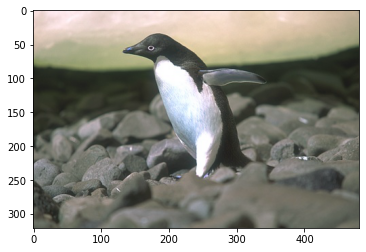

In [97]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/7.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/7.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/7.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
plt.imshow(im)

In [98]:
O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

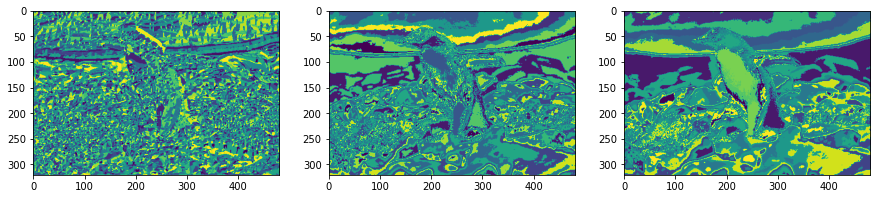

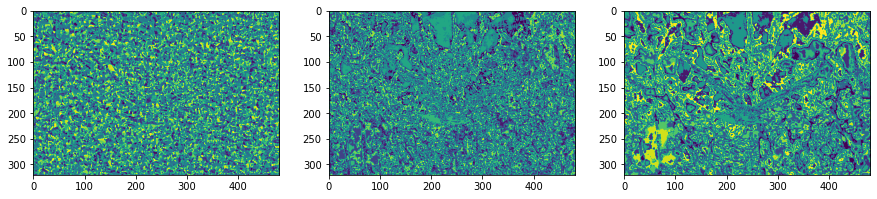

In [100]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/6.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/6.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/6.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
# plt.imshow(im)

O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

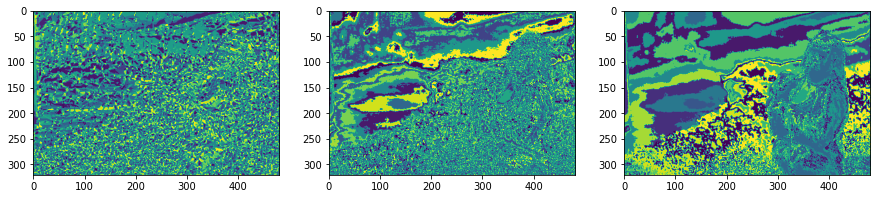

In [101]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/5.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/5.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/5.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
# plt.imshow(im)

O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

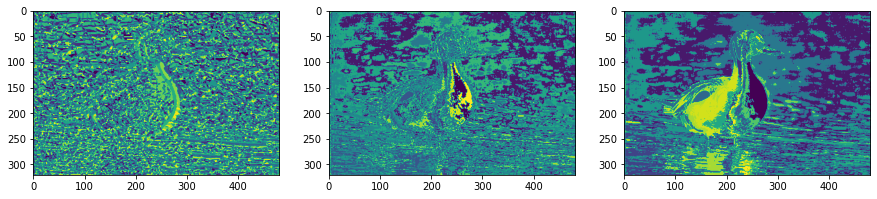

In [102]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/4.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/4.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/4.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
# plt.imshow(im)

O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

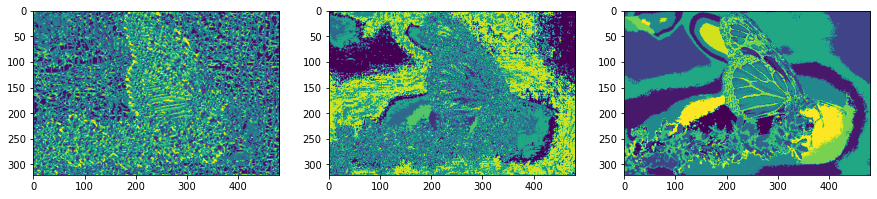

In [103]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/3.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/3.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/3.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
# plt.imshow(im)

O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

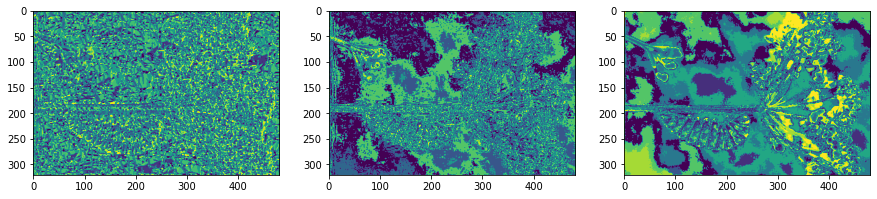

In [104]:
path = '/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/Images/2.jpg'
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/2.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/2.png',0)
im = cv2.imread(path)

imGray = im[:,:,0]
# plt.imshow(im)

O_response = getFilterResponse(imGray,OrientedDoGFilterBank)
L_response = getFilterResponse(imGray,LMFilterBank)
G_response = getFilterResponse(imGray,gaborFilterBank)
FilterResponse = np.dstack((O_response,G_response,L_response))

Tmap = do_Kmeans(FilterResponse,K= 64 )
Bmap = do_Kmeans(imGray,K= 16)
Cmap = do_Kmeans(im,K=16) 
partition = np.ones((Bmap.shape[0],20))*255

fx,plts = plt.subplots(1,3,figsize = [15,5])
plts[0].imshow(Tmap)
plts[1].imshow(Bmap)
plts[2].imshow(Cmap)

In [91]:
num_bins = 64 
DiskBanks = [HalfDiskBank1,HalfDiskBank2,HalfDiskBank3]
n_Diskpairs = 8

T_g = getGradient(Tmap,num_bins,DiskBanks,n_Diskpairs)
B_g = getGradient(Bmap,num_bins,DiskBanks,n_Diskpairs)
C_g = getGradient(Cmap,num_bins,DiskBanks,n_Diskpairs)

A = (T_g+B_g+C_g)/3

w1,w2 = 0.5,0.5
B = w1*Canny+w2*Sobel
pb = np.multiply(A, B)

pb = cv2.normalize(pb, None, 0, 255, cv2.NORM_MINMAX)

(-0.5, 1482.5, 320.5, -0.5)

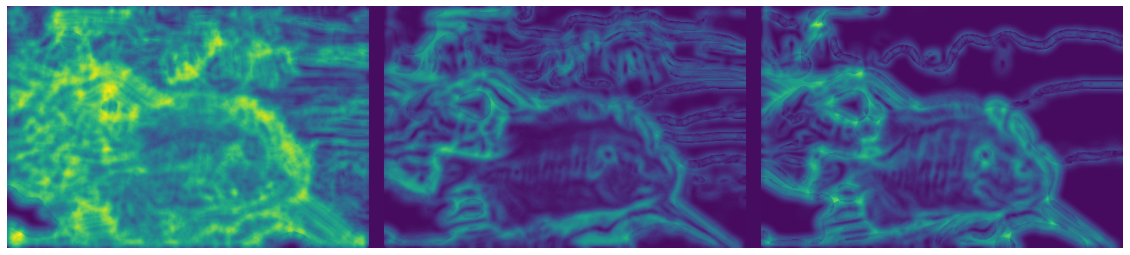

In [92]:
plt.figure(figsize = (20,5))
plt.imshow(np.hstack((T_g,partition,B_g,partition,C_g)))
plt.axis('off')

(-0.5, 1482.5, 320.5, -0.5)

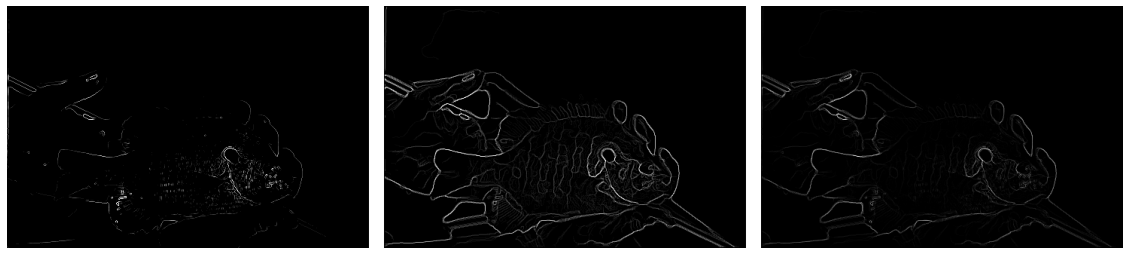

In [93]:

plt.figure(figsize = (20,5))
plt.imshow(np.hstack((Sobel,partition,Canny,partition,pb)),'gray')
plt.axis('off')

# plt.savefig("/home/gokul/CMSC733/hgokul_hw0/Phase1/Outputs/1.png", bbox_inches='tight')

# Combine all Responses

In [118]:

O_response.shape,G_response.shape,L_response.shape,FilterResponse.shape

((321, 481, 16), (321, 481, 40), (321, 481, 48), (321, 481, 104))

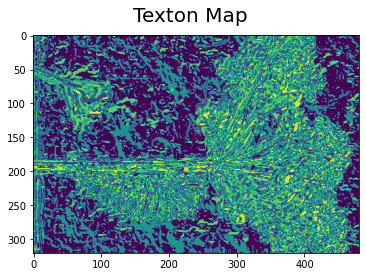

In [127]:
Tmap = do_Kmeans(O_response,K= 64 )

fig = plt.figure()
plt.imshow(Tmap)
fig.suptitle("Texton Map", fontsize=20)

imNameSplit = imName.split('.')
fileName = "TextonMap_" + imNameSplit[0] + ".png"
plt.savefig(fileName)

In [121]:
imName = '2.jpg'

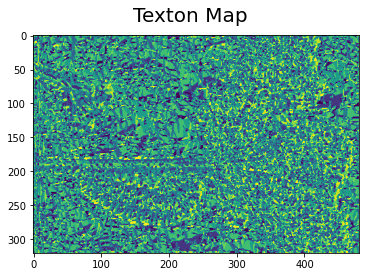

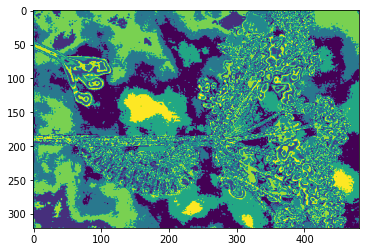

In [42]:
# Brightness Map


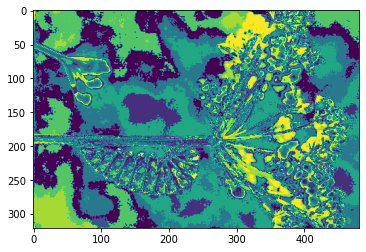

In [43]:
# ColorMap
Cmap = do_Kmeans(im,K=16) 

# im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# Cmap_rgb = do_KmeansCV(im_rgb,K=16)

# im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
# Cmap_hsv = do_KmeansCV(im_hsv,K=16)

plt.imshow(Cmap)

8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8


# Without Normalisation

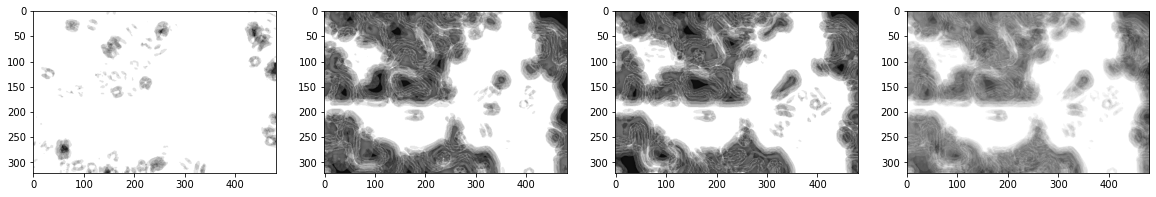

In [45]:
A = (T_g+B_g+C_g)/3

fx,plts = plt.subplots(1,4,figsize = [20,10])
plts[0].imshow(T_g,'gray')
plts[1].imshow(B_g,'gray')
plts[2].imshow(C_g,'gray')
plts[3].imshow(A,'gray')


In [46]:
Canny = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/CannyBaseline/2.png',0)
Sobel = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/SobelBaseline/2.png',0)
GroundTruth = cv2.imread('/home/gokul/CMSC733/hgokul_hw0/Phase1/BSDS500/GroundTruth/2.png',0)
w1,w2 = 0.5,0.5
B = w1*Canny+w2*Sobel
pb = np.multiply(A, B)

cv2.normalize(pb, pb, 0, 255, cv2.NORM_MINMAX)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 44.5581568 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , 35.00668142, 16.06433364, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 15.73827976, 27.3397487 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

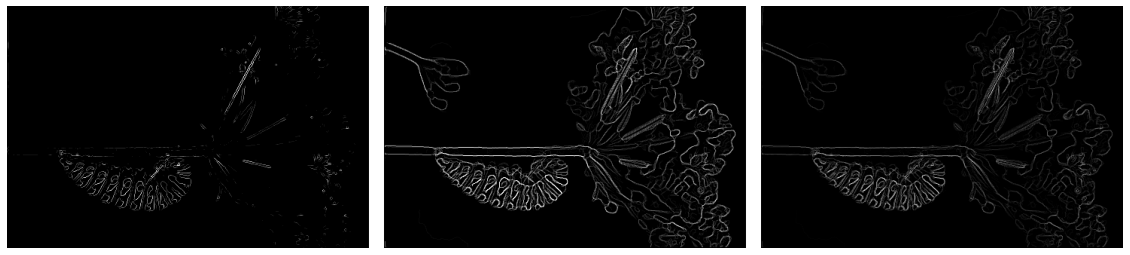

In [47]:
partition = np.ones((pb.shape[0],20))*255

plt.figure(figsize = (20,5))
plt.imshow(np.hstack((Sobel,partition,Canny,partition,pb)),'gray')
plt.axis('off')
plt.savefig("/home/gokul/CMSC733/hgokul_hw0/Phase1/Outputs/1.png", bbox_inches='tight')